# Analysis of Experiment 1 (Ice Cream)

El experimento IceCream consiste en variar el porcentaje del training set del 10% al 80% con 10 particiones.  
En cada experimento se realiza un método de ablación donde se entrenan 32 modelos variando las vistas que se usan en su entrenamiento. El test size se mantuvo como 20%. Se realizaron dos splits de los datos dondel al principio se parten en 20% para testing y luego 80% para training, de los cuales de ese 80% se vuelve a hacer el split en el train size especificado. El mismo random state se mantiene alrededor de un mismo experimento.

Load the required libraries.

In [1]:
# ============================
# Standard Library Imports
# ============================
from pathlib import Path
import json
import time
import pickle


# ============================
# Third-Party Library Imports
# ============================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import normaltest, kstest, mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt



## Configurations

sns.set_style('darkgrid')

# ============================
# Local Application Imports
# ============================

from analysis.visualization import (
    plot_tda_comparison,
    plot_violin_f1,
)

from analysis.metrics_extraction import (
    analyze_experiments, 
    perform_statistical_test,
    read_json_files,
    build_grouped_results
)

Start loading the data by selecting the directory where the JSON files are located.

In [9]:
exp_name = "exp_icecream"
results_path = Path.cwd() / "results" / exp_name

For every JSON file in `results_path` the function `read_json_files` generates a ModelResult object. This object represents the results for an individual experiment. The function `build_grouped_results` reads a list of ModelResult and organizes them by trainsplit and by group of models that shares the same used views.

In [10]:
# Measure execution time
start_time = time.time()

models_results = build_grouped_results(read_json_files(results_path))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

Execution time: 88.099634 seconds


Select the models trained with 80\% of data.

In [11]:
models_grouped_trainsize_80 = models_results.get_split(0.80)

In [6]:
serialize = True
if serialize:
    path = Path.cwd() / "results_pickle" / exp_name
    with open(path, "wb") as f:
        pickle.dump(models_grouped_trainsize_80, f)

Select the list of accuracy for the 30 experiments of the 'original' model.

In [12]:
set_acc_original = np.array(models_grouped_trainsize_80.model_groups.get('original').acc_scores())

Visualize how the accuracies are distributed

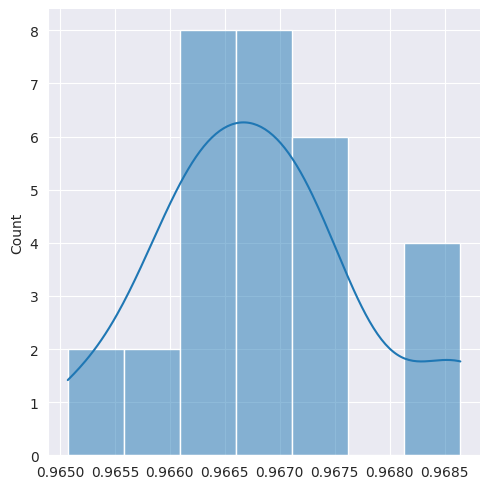

In [13]:
sns.displot(set_acc_original, kde=True, bins=7, stat='count')

It might seems that the distribution follows a normal behaviour. More tests needs to be made to assess the distribution. The Q-Q plot shows that may not follow a normal distribution. 

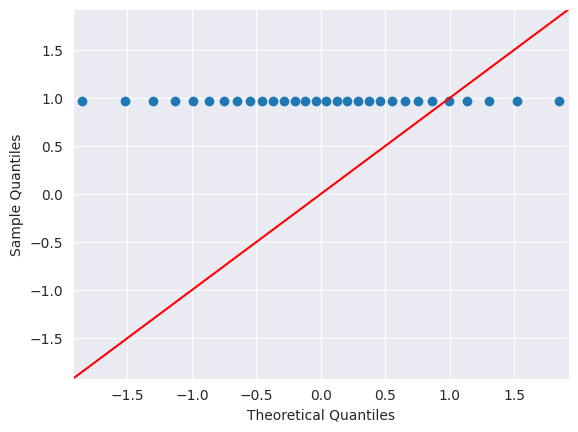

In [14]:
sm.qqplot(set_acc_original, line ='45')
plt.show()

We apply a Kolmogorov-Smirnov test for assess normality. The null hypothesis $H_0$ is that the sample distribution is normaly distributed. The alternative hypothesis $H_a$ is that the sample distribution is not normal.

In [8]:
res_normal_test = normaltest(set_acc_original)

In [9]:
print(f"The p-value {res_normal_test.pvalue}")

The p-value 0.5944514719640683


In [10]:
res_normal_test_ks = kstest(set_acc_original, 'norm')

In [11]:
print(f"The p-value {res_normal_test_ks.pvalue}")

The p-value 1.2515462264049771e-23


The results shows that the normal test based on D'Agostino and Pearson that combines the skew and kurtosis, rejects the alternative hypothesis. However the Kolmogorov-Smirnov test rejects the null hypothesis.

I reject the null hypothesis, but I think that with more data, it may behaves like a normal distribution.

In [15]:
print(f"Base model mean accuracy: {set_acc_original.mean()} and error {set_acc_original.std()}")

Base model mean accuracy: 0.9668238095238094 and error 0.0009450431608999149


Select the list of accuracies for experiment "original-tda".

In [13]:
set_acc_originaltda = np.array(models_grouped_trainsize_80.model_groups.get('original-tda').acc_scores())

Visualization of the distribution

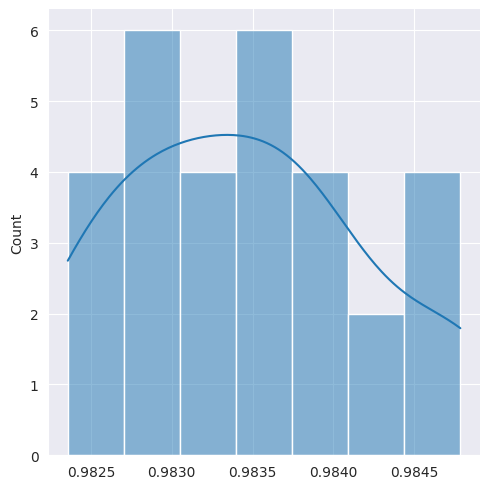

In [14]:
sns.displot(set_acc_originaltda, kde=True, bins=7, stat='count')

Calculate average mean and standard deviation of accuracy original-tda.

In [15]:
print(f"Original-TDA mean accuracy: {set_acc_originaltda.mean()} and error {set_acc_originaltda.std()}")

Original-TDA mean accuracy: 0.983447619047619 and error 0.0007520795056152229


It seems that it does not follows a normal distribution.

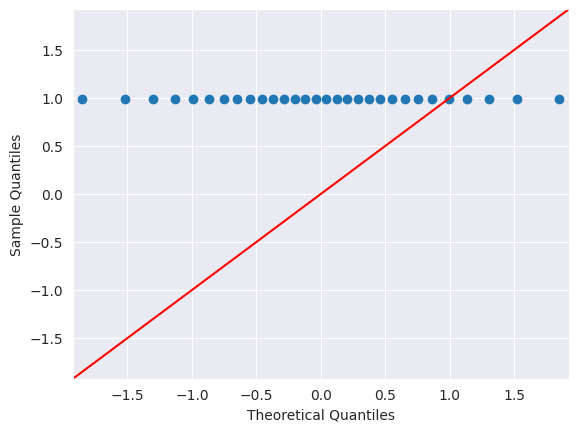

In [16]:
sm.qqplot(set_acc_originaltda, line ='45')
plt.show()

In [17]:
res_ks = kstest(set_acc_originaltda, 'norm')

In [20]:
print(f"Kolmogorov-Smirnov test in Original-TDA model: {res_ks.pvalue}")

Kolmogorov-Smirnov test in Original-TDA model: 5.563594599759451e-24


The distribution does not follow a normal distribution.

Test a non-parametric hypothesis test

We performed a Mann Whitney test: the null hypothesis is that the distribution underlying the set of accuracies of original-tda is the same as the set of accuracy of original model. The alternative hypothesis is that the distribution is greater than the original distribution. (confidence level of 95%)

In [21]:
U1, pvalue = mannwhitneyu(set_acc_originaltda, set_acc_original, alternative="greater")

In [22]:
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.409023034810735e-11 assess that the alternative hypothesis is accepted.


We plot the boxplot of both sets.

<Axes: >

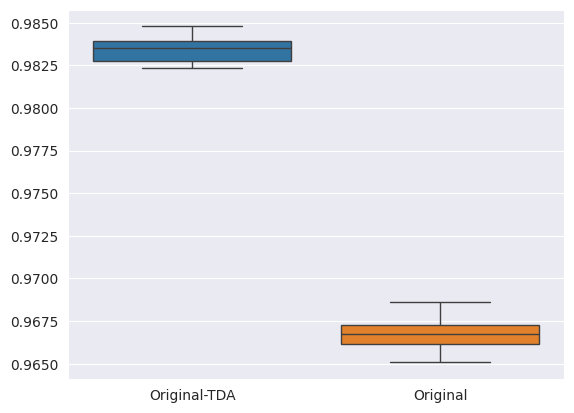

In [23]:
df = pd.Series(set_acc_originaltda, name="Original-TDA").to_frame().join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

##### Analisis of distribution original-top_left

Select the model Original-Top_left trained with 80% of data, and extract the accuracies across all experiments

In [24]:
set_acc_originalTL = np.array(models_grouped_trainsize_80.model_groups.get('original-top_left').acc_scores())

Display the histogram

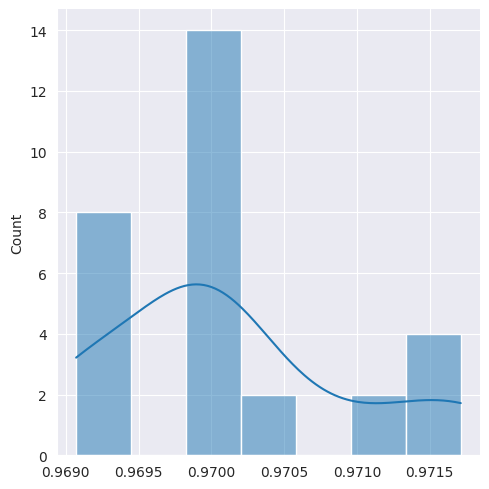

In [25]:
sns.displot(set_acc_originalTL, kde=True, bins=7, stat='count')

In [26]:
normal_test = normaltest(set_acc_originalTL)
normal_test.pvalue

0.23241034662532842

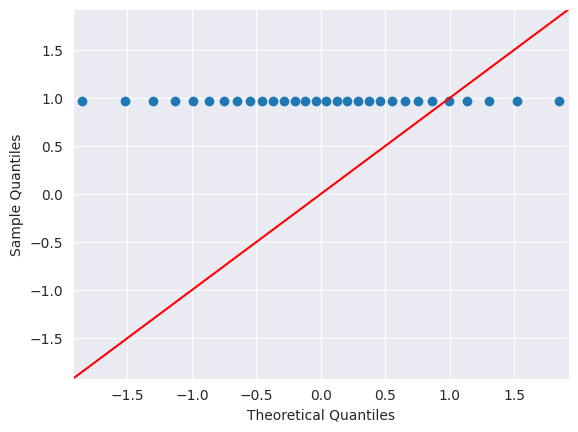

In [27]:
sm.qqplot(set_acc_originalTL, line ='45')
plt.show()

In [28]:
print(f"Base model mean accuracy: {set_acc_originalTL.mean()} and error {set_acc_originalTL.std()}")

Base model mean accuracy: 0.970104761904762 and error 0.0008308943901172754


<Axes: >

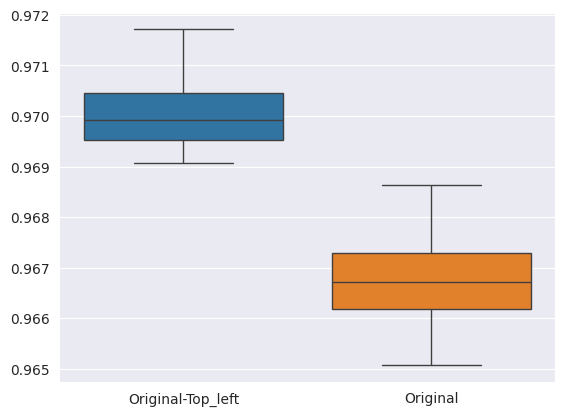

In [29]:
df = pd.Series(set_acc_originalTL, name="Original-Top_left").to_frame().join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

In [30]:
U1, pvalue = mannwhitneyu(set_acc_originalTL, set_acc_original, alternative="greater")

In [31]:
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.3669515439290332e-11 assess that the alternative hypothesis is accepted.


We want to compare how the original-top_left compares with original-tda

<Axes: >

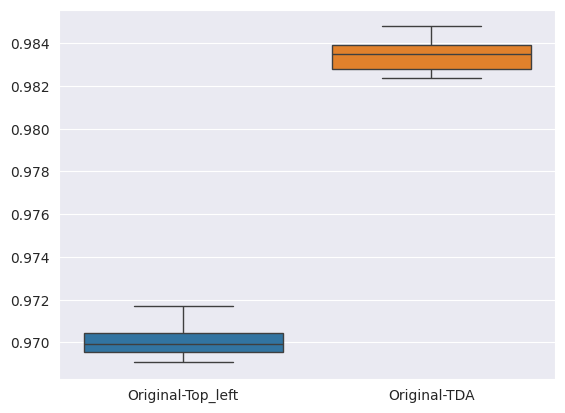

In [32]:
df = pd.Series(set_acc_originalTL, name="Original-Top_left").to_frame().join(pd.Series(set_acc_originaltda, name="Original-TDA"))
sns.boxplot(data=df)

In [33]:
U1, pvalue = mannwhitneyu(set_acc_originaltda, set_acc_originalTL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.3669515439290332e-11 assess that the alternative hypothesis is accepted.


##### Analisis of distribution of bottom left original

In [54]:
set_acc_originalBL = np.array(models_grouped_trainsize_80.model_groups.get('bottom_left-original').acc_scores())

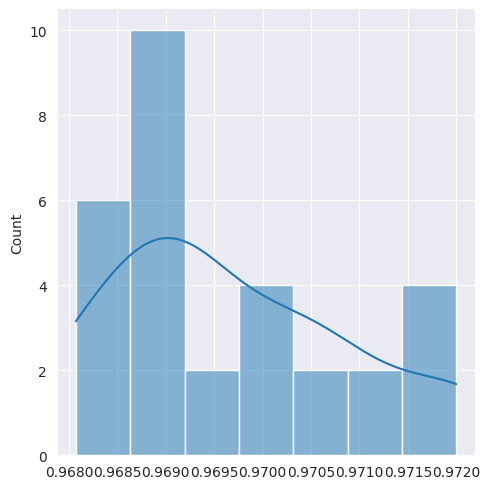

In [35]:
sns.displot(set_acc_originalBL, kde=True, bins=7, stat='count')

In [36]:
normal_test = normaltest(set_acc_originalBL)
normal_test.pvalue

0.27213639415400925

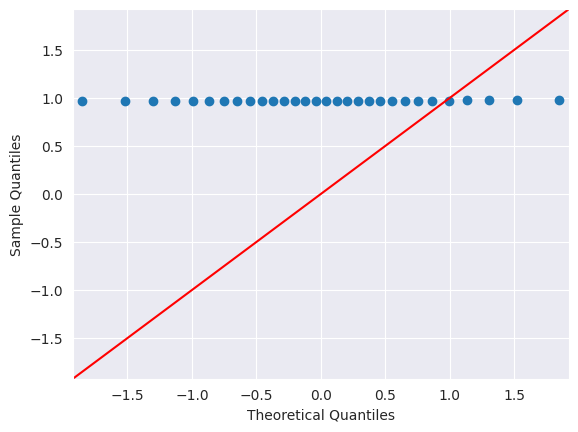

In [37]:
sm.qqplot(set_acc_originalBL, line ='45')
plt.show()

In [38]:
print(f"Base model mean accuracy: {set_acc_originalBL.mean()} and error {set_acc_originalBL.std()}")

Base model mean accuracy: 0.9696952380952382 and error 0.0012309684994799878


<Axes: >

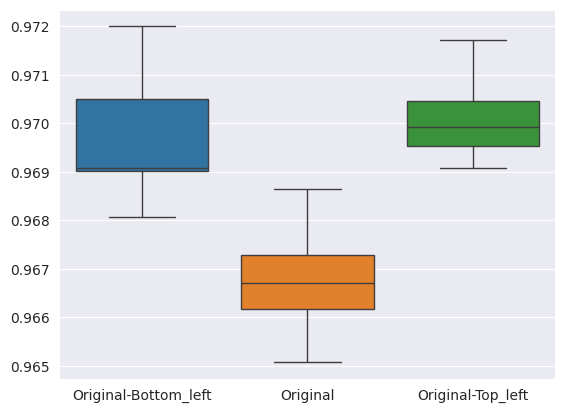

In [39]:
df = pd.Series(set_acc_originalBL, name="Original-Bottom_left").to_frame().join(pd.Series(set_acc_original, name="Original")).join(pd.Series(set_acc_originalTL, name="Original-Top_left"))
sns.boxplot(data=df)

In [40]:
U1, pvalue = mannwhitneyu(set_acc_originalBL, set_acc_original, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.4313688081863172e-10 assess that the alternative hypothesis is accepted.


We want to determine if the distribution of original top-left is greater than bottom-left

In [41]:
U1, pvalue = mannwhitneyu(set_acc_originalTL, set_acc_originalBL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.054580852640039576 assess that the alternative hypothesis is rejected.


We reject the alternative hypothesis. The distribution of Top-left is not greater than Bottom left

##### Analisis of distribution of original-top_right

In [42]:
set_acc_originalTR = np.array(models_grouped_trainsize_80.model_groups.get('original-top_right').acc_scores())

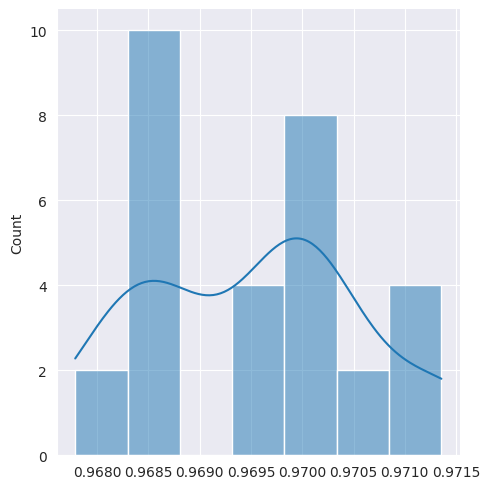

In [44]:
sns.displot(set_acc_originalTR, kde=True, bins=7, stat='count')

In [45]:
normal_test = normaltest(set_acc_originalTR)
normal_test.pvalue

0.38666386820959325

We keep the null hypothesis that the skew and kurtosis of the distribution follows a normal distribution

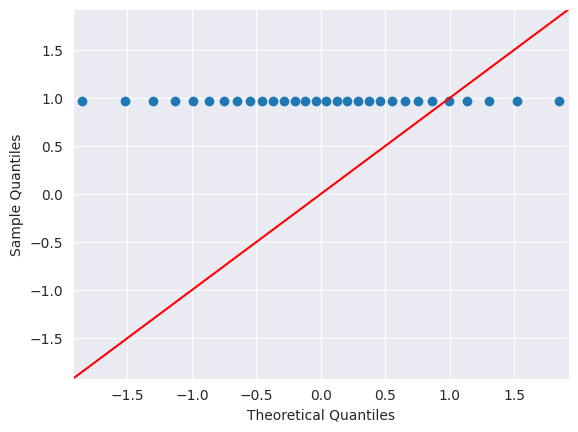

In [46]:
sm.qqplot(set_acc_originalTR, line ='45')
plt.show()

In [47]:
print(f"Base model mean accuracy: {set_acc_originalTR.mean()} and error {set_acc_originalTR.std()}")

Base model mean accuracy: 0.9695333333333335 and error 0.0010513569678862126


<Axes: >

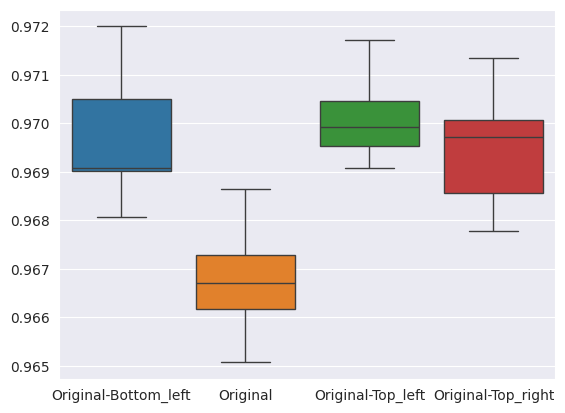

In [48]:
df = pd.Series(set_acc_originalBL, name="Original-Bottom_left").to_frame().join(pd.Series(set_acc_original, name="Original")).join(pd.Series(set_acc_originalTL, name="Original-Top_left")).join(pd.Series(set_acc_originalTR, name="Original-Top_right"))
sns.boxplot(data=df)

In [50]:
U1, pvalue = mannwhitneyu(set_acc_originalTR, set_acc_original, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 3.165686635698482e-10 assess that the alternative hypothesis is accepted.


We accept the alternative hypothesis that distribution of TR is greater than Original.

In [51]:
U1, pvalue = mannwhitneyu(set_acc_originalTR, set_acc_originalBL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.6744269226824052 assess that the alternative hypothesis is accepted.


In [52]:
U1, pvalue = mannwhitneyu(set_acc_originalTL, set_acc_originalTR, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.02560356267831325 assess that the alternative hypothesis is rejected.


##### Analisis distribution of bottom_right-original

In [55]:
set_acc_originalBR = np.array(models_grouped_trainsize_80.model_groups.get('bottom_right-original').acc_scores())

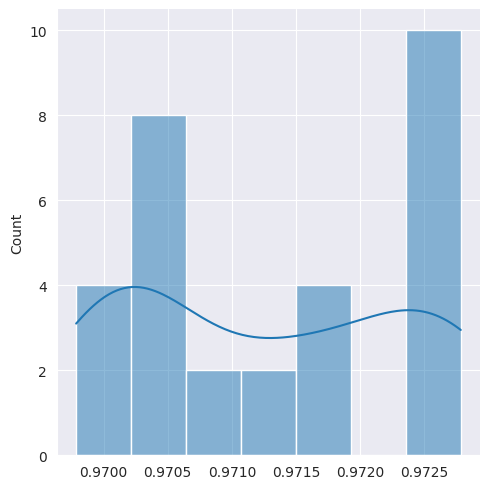

In [56]:
sns.displot(set_acc_originalBR, kde=True, bins=7, stat='count')

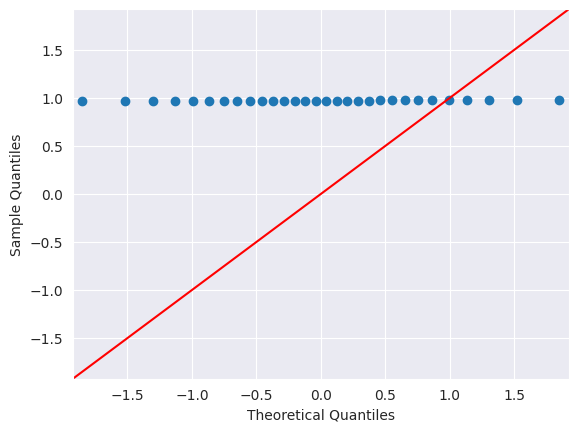

In [57]:
sm.qqplot(set_acc_originalBR, line ='45')
plt.show()

In [58]:
print(f"Base model mean accuracy: {set_acc_originalBR.mean()} and error {set_acc_originalBR.std()}")

Base model mean accuracy: 0.9712761904761905 and error 0.0010753473309057739


<Axes: >

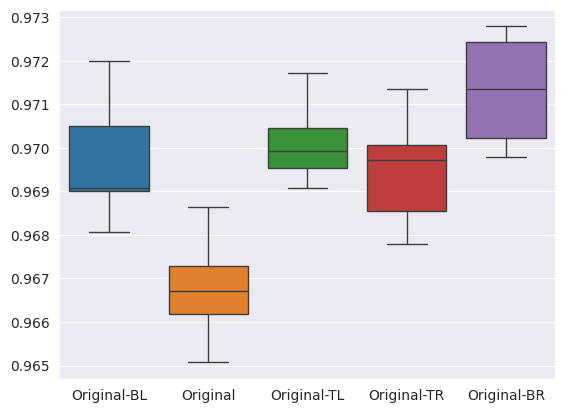

In [60]:
df = pd.Series(set_acc_originalBL, name="Original-BL").to_frame().join(pd.Series(set_acc_original, name="Original")).join(pd.Series(set_acc_originalTL, name="Original-TL")).join(pd.Series(set_acc_originalTR, name="Original-TR")).join(pd.Series(set_acc_originalBR, name="Original-BR"))
sns.boxplot(data=df)

In [61]:
U1, pvalue = mannwhitneyu(set_acc_originalBR, set_acc_original, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.3531845599979525e-11 assess that the alternative hypothesis is accepted.


In [62]:
U1, pvalue = mannwhitneyu(set_acc_originalBR, set_acc_originalTR, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.4968248790398447e-07 assess that the alternative hypothesis is accepted.


In [63]:
U1, pvalue = mannwhitneyu(set_acc_originalBR, set_acc_originalTL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.4918210599777065e-05 assess that the alternative hypothesis is accepted.


In [64]:
U1, pvalue = mannwhitneyu(set_acc_originalBR, set_acc_originalBL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 3.198821463368321e-05 assess that the alternative hypothesis is accepted.


<Axes: >

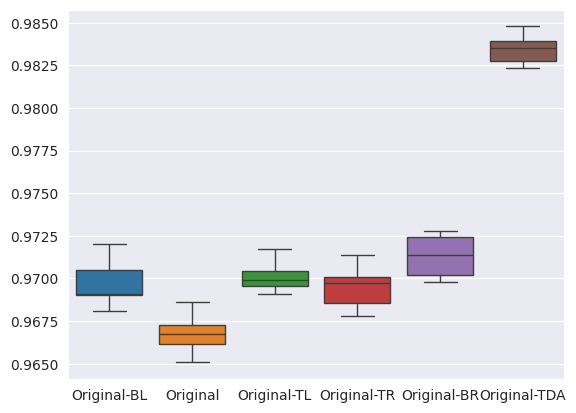

In [65]:
df = pd.Series(set_acc_originalBL, name="Original-BL").to_frame().join(pd.Series(set_acc_original, name="Original")).join(pd.Series(set_acc_originalTL, name="Original-TL")).join(pd.Series(set_acc_originalTR, name="Original-TR")).join(pd.Series(set_acc_originalBR, name="Original-BR")).join(pd.Series(set_acc_originaltda, name="Original-TDA"))
sns.boxplot(data=df)

#### Analisis of three views

In [67]:
set_acc_originalTLD = np.array(models_grouped_trainsize_80.model_groups.get('original-tda-top_left').acc_scores())

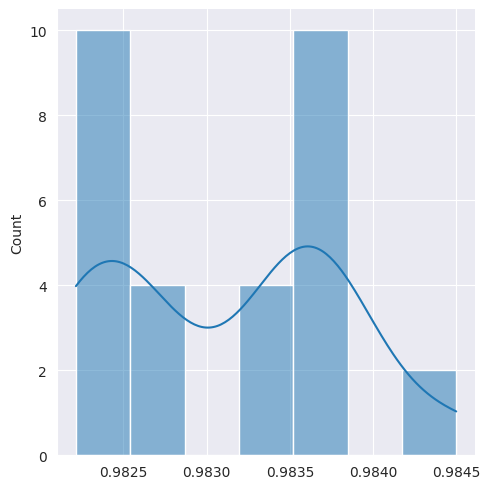

In [68]:
sns.displot(set_acc_originalTLD, kde=True, bins=7, stat='count')

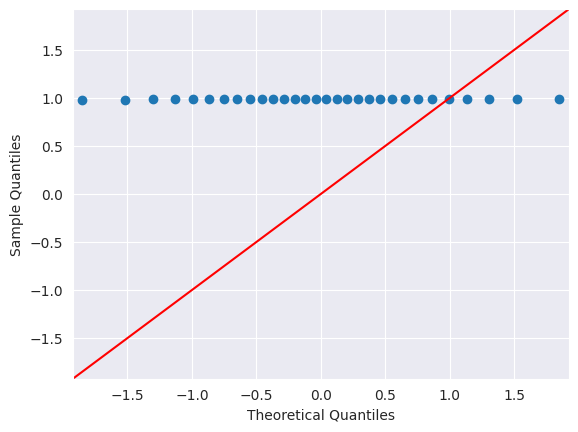

In [69]:
sm.qqplot(set_acc_originalTLD, line ='45')
plt.show()

<Axes: >

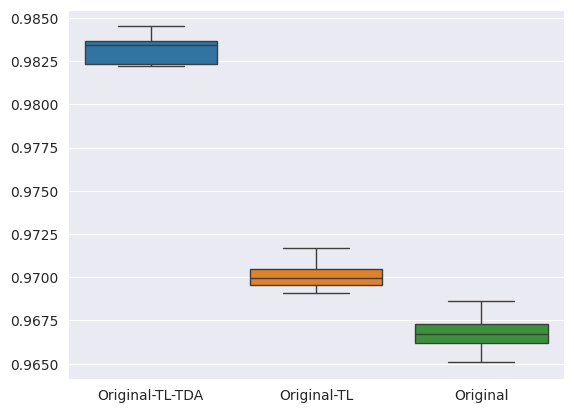

In [70]:
df = pd.Series(set_acc_originalTLD, name="Original-TL-TDA").to_frame().join(pd.Series(set_acc_originalTL, name="Original-TL")).join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

In [71]:
print(f"Original TL-TDA mean accuracy: {set_acc_originalTLD.mean()} and error {set_acc_originalTLD.std()}")

Original TL-TDA mean accuracy: 0.9831238095238096 and error 0.0006922636961038286


<Axes: >

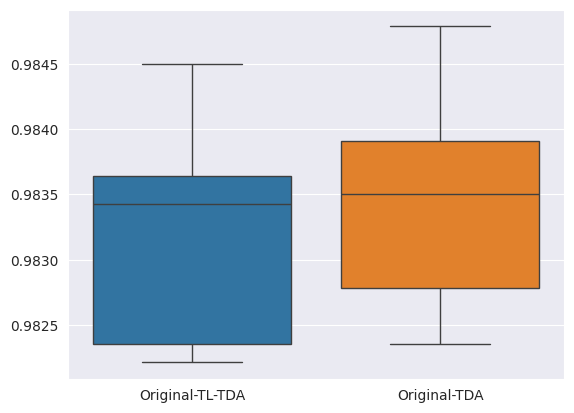

In [72]:
df = pd.Series(set_acc_originalTLD, name="Original-TL-TDA").to_frame().join(pd.Series(set_acc_originaltda, name="Original-TDA"))
sns.boxplot(data=df)

In [75]:
U1, pvalue = mannwhitneyu(set_acc_originalTLD, set_acc_originaltda, alternative="two-sided")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.08567485108668413 assess that the alternative hypothesis is rejected.


We found that de distributions from TLD and TDA are the same.

##### Analisis of bottom_left-original-tda

In [76]:
set_acc_originalBLD = np.array(models_grouped_trainsize_80.model_groups.get('bottom_left-original-tda').acc_scores())

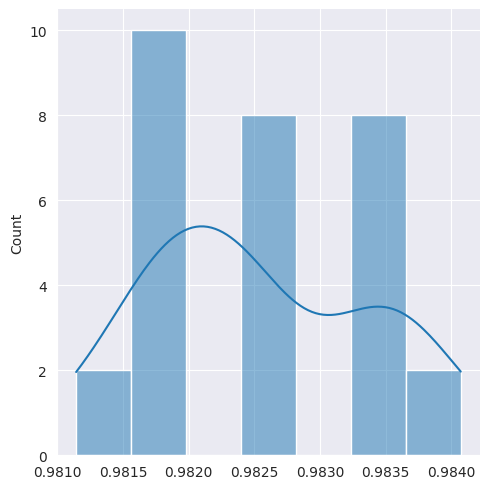

In [79]:
sns.displot(set_acc_originalBLD, kde=True, bins=7, stat='count')

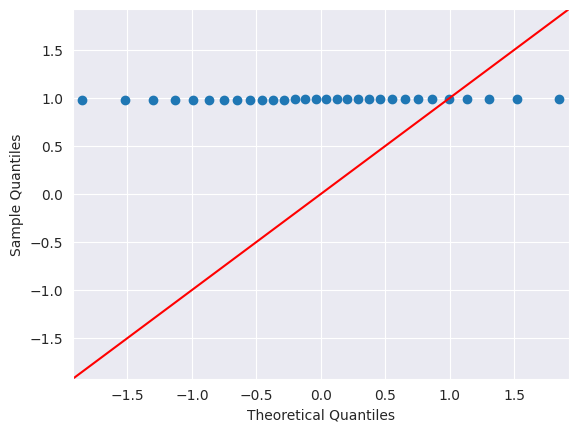

In [80]:
sm.qqplot(set_acc_originalBLD, line ='45')
plt.show()

In [81]:
print(f"Original TL-TDA mean accuracy: {set_acc_originalBLD.mean()} and error {set_acc_originalBLD.std()}")

Original TL-TDA mean accuracy: 0.9825380952380953 and error 0.0008333469386644479


<Axes: >

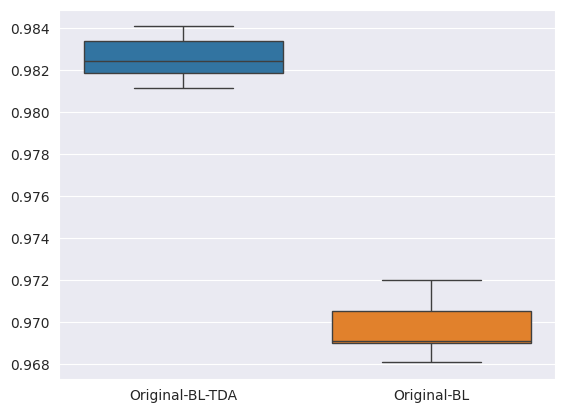

In [82]:
df = pd.Series(set_acc_originalBLD, name="Original-BL-TDA").to_frame().join(pd.Series(set_acc_originalBL, name="Original-BL"))
sns.boxplot(data=df)

<Axes: >

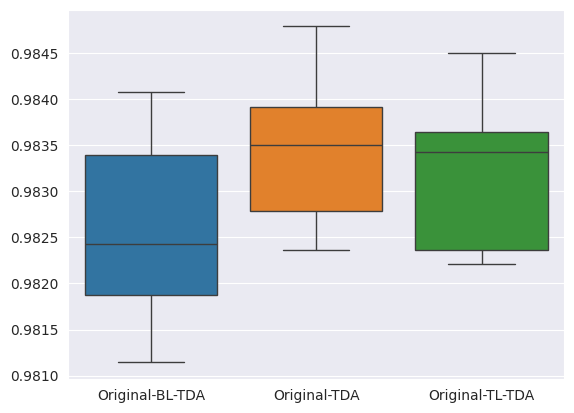

In [84]:
df = pd.Series(set_acc_originalBLD, name="Original-BL-TDA").to_frame().join(pd.Series(set_acc_originaltda, name="Original-TDA")).join(pd.Series(set_acc_originalTLD, name="Original-TL-TDA"))
sns.boxplot(data=df)

In [86]:
U1, pvalue = mannwhitneyu(set_acc_originalBLD, set_acc_originaltda, alternative="two-sided")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 0.00034901487767206407 assess that the alternative hypothesis is accepted.


In [87]:
U1, pvalue = mannwhitneyu(set_acc_originalBLD, set_acc_originaltda, alternative="less")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 0.00017450743883603204 assess that the alternative hypothesis is accepted.


We found that the distribution of original tda is greater than bottom left tda

In [89]:
U1, pvalue = mannwhitneyu(set_acc_originalBLD, set_acc_originalTLD, alternative="less")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 0.0035545737372078673 assess that the alternative hypothesis is accepted.


We found that BL-TDA distribution is less that TL TDA

##### Analisis of original-tda-top_right distribution

In [90]:
set_acc_originalTRD = np.array(models_grouped_trainsize_80.model_groups.get('original-tda-top_right').acc_scores())

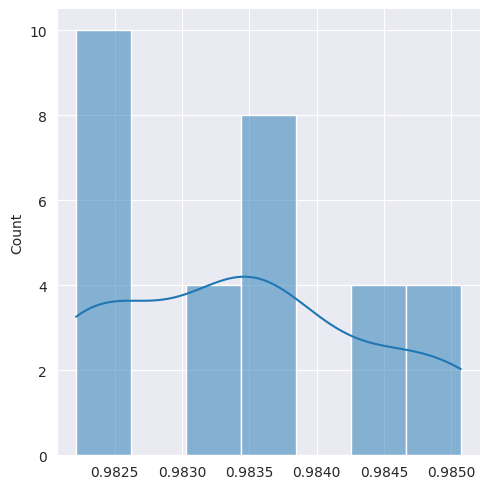

In [91]:
sns.displot(set_acc_originalTRD, kde=True, bins=7, stat='count')

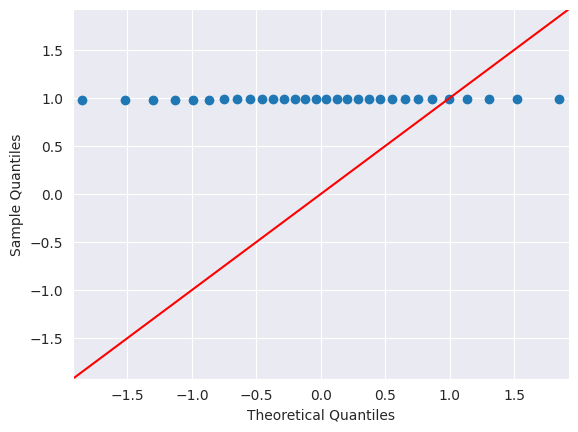

In [92]:
sm.qqplot(set_acc_originalTRD, line ='45')
plt.show()

<Axes: >

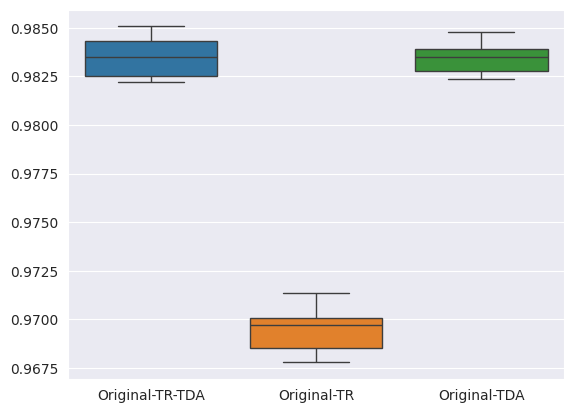

In [95]:
df = pd.Series(set_acc_originalTRD, name="Original-TR-TDA").to_frame().join(pd.Series(set_acc_originalTR, name="Original-TR")).join(pd.Series(set_acc_originaltda, name="Original-TDA"))
sns.boxplot(data=df)

In [94]:
print(f"TRD mean accuracy: {set_acc_originalTRD.mean()} and error {set_acc_originalTRD.std()}")

TRD mean accuracy: 0.9834571428571431 and error 0.00096037124341063


In [96]:
U1, pvalue = mannwhitneyu(set_acc_originalTRD, set_acc_originaltda, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 0.5734525344096393 assess that the alternative hypothesis is accepted.


We reject the alternative hypothesis.

##### Analysis distribution bottom_right-original-tda

In [97]:
set_acc_originalBRD = np.array(models_grouped_trainsize_80.model_groups.get('bottom_right-original-tda').acc_scores())

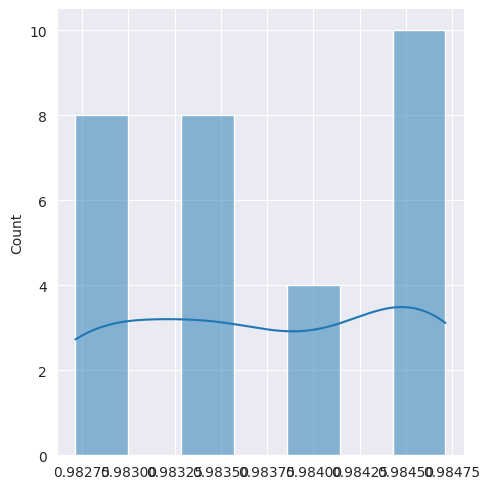

In [103]:
sns.displot(set_acc_originalBRD, kde=True, bins=7, stat='count')

In [114]:
print(f"TRD mean accuracy: {set_acc_originalBRD.mean()} and error {set_acc_originalBRD.std()}")

TRD mean accuracy: 0.9837428571428573 and error 0.0007412987316351097


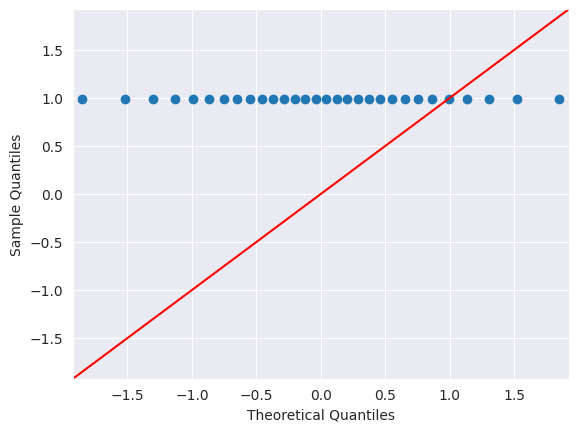

In [104]:
sm.qqplot(set_acc_originalBRD, line ='45')
plt.show()

<Axes: >

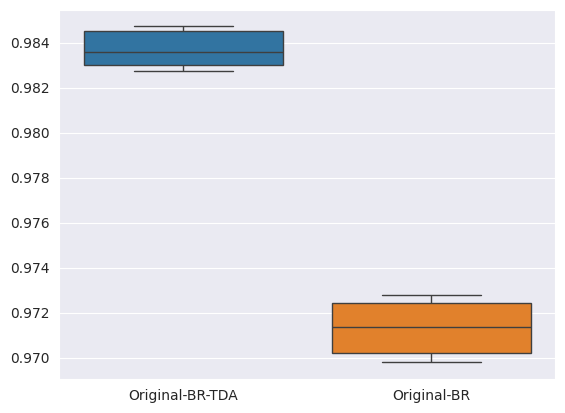

In [105]:
df = pd.Series(set_acc_originalBRD, name="Original-BR-TDA").to_frame().join(pd.Series(set_acc_originalBR, name="Original-BR"))
sns.boxplot(data=df)

<Axes: >

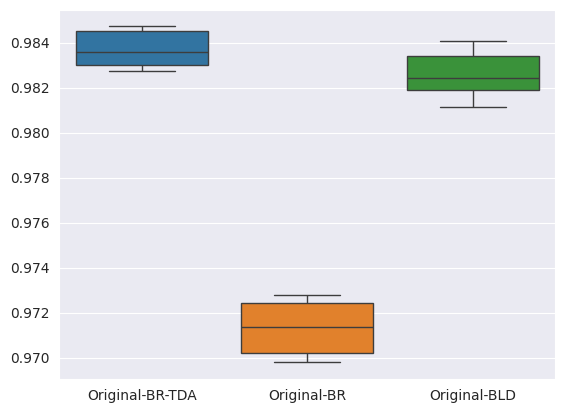

In [106]:
df = pd.Series(set_acc_originalBRD, name="Original-BR-TDA").to_frame().join(pd.Series(set_acc_originalBR, name="Original-BR")).join(pd.Series(set_acc_originalBLD, name="Original-BLD"))
sns.boxplot(data=df)

In [108]:
U1, pvalue = mannwhitneyu(set_acc_originalBRD, set_acc_originaltda, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.09235091191108885 assess that the alternative hypothesis is rejected.


In [110]:
U1, pvalue = mannwhitneyu(set_acc_originalBRD, set_acc_originalBLD, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.2665732782950634e-06 assess that the alternative hypothesis is accepted.


#### Analisis bottom left, original, top left

In [112]:
set_acc_originalBLTL = np.array(models_grouped_trainsize_80.model_groups.get('bottom_left-original-top_left').acc_scores())

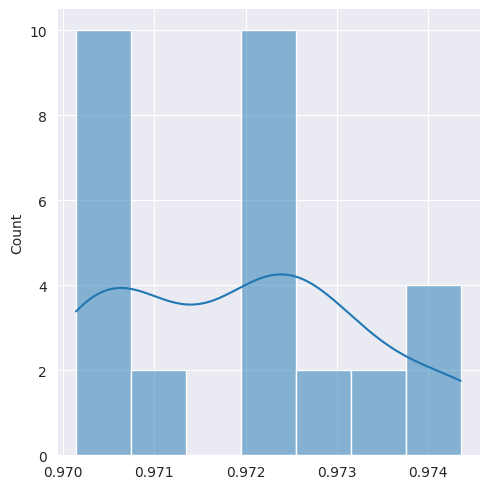

In [113]:
sns.displot(set_acc_originalBLTL, kde=True, bins=7, stat='count')

In [115]:
print(f"{set_acc_originalBLTL.mean()} and error {set_acc_originalBLTL.std()}")

0.9719714285714287 and error 0.0013709324499452545


<Axes: >

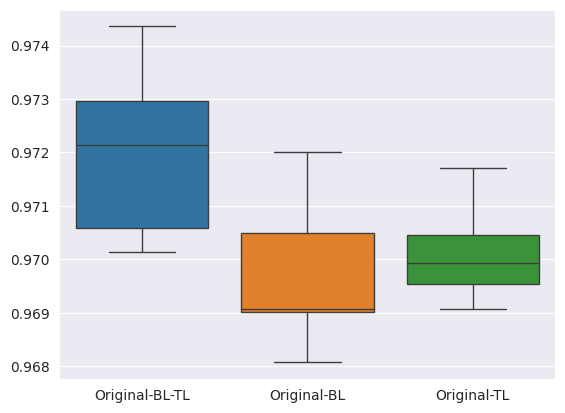

In [116]:
df = pd.Series(set_acc_originalBLTL, name="Original-BL-TL").to_frame().join(pd.Series(set_acc_originalBL, name="Original-BL")).join(pd.Series(set_acc_originalTL, name="Original-TL"))
sns.boxplot(data=df)

In [119]:
U1, pvalue = mannwhitneyu(set_acc_originalBLTL, set_acc_originalBL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 7.997117613039487e-08 assess that the alternative hypothesis is accepted.


In [120]:
U1, pvalue = mannwhitneyu(set_acc_originalBLTL, set_acc_originalTL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 5.677396570949428e-08 assess that the alternative hypothesis is accepted.


<Axes: >

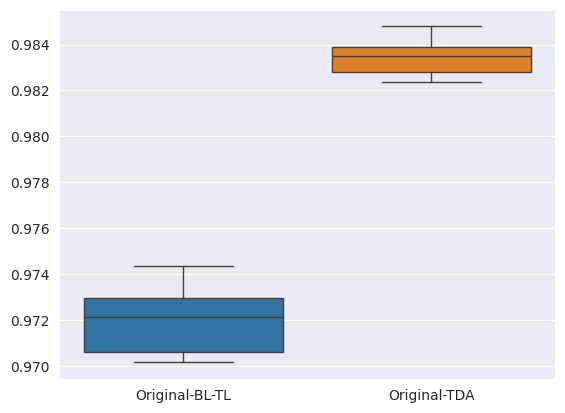

In [121]:
df = pd.Series(set_acc_originalBLTL, name="Original-BL-TL").to_frame().join(pd.Series(set_acc_originaltda, name="Original-TDA"))
sns.boxplot(data=df)

#### Analisis of original-top_left-top_right

In [122]:

set_acc_originalTLTR = np.array(models_grouped_trainsize_80.model_groups.get('original-top_left-top_right').acc_scores())

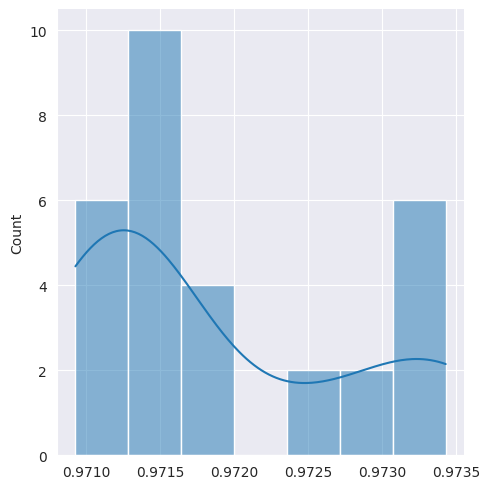

In [123]:
sns.displot(set_acc_originalTLTR, kde=True, bins=7, stat='count')

In [124]:
print(f"{set_acc_originalTLTR.mean()} and error {set_acc_originalTLTR.std()}")

0.9718666666666667 and error 0.0009246682312421266


<Axes: >

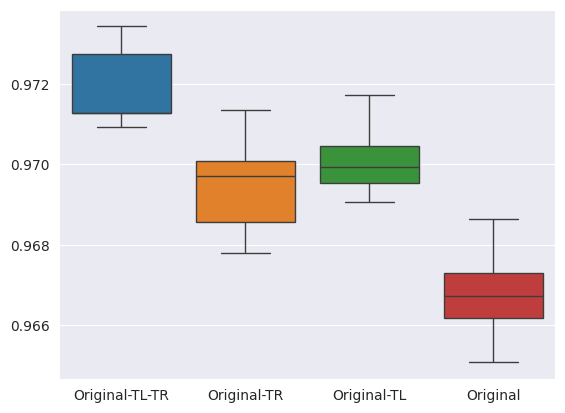

In [126]:
df = pd.Series(set_acc_originalTLTR, name="Original-TL-TR").to_frame().join(pd.Series(set_acc_originalTR, name="Original-TR")).join(pd.Series(set_acc_originalTL, name="Original-TL")).join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

In [127]:
U1, pvalue = mannwhitneyu(set_acc_originalTLTR, set_acc_originalTR, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 5.2782497649719695e-09 assess that the alternative hypothesis is accepted.


In [128]:
U1, pvalue = mannwhitneyu(set_acc_originalTLTR, set_acc_originalTL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 5.4952982576510056e-08 assess that the alternative hypothesis is accepted.


#### Analisis of bottom_right-original-top_left

In [129]:

set_acc_originalBRTL = np.array(models_grouped_trainsize_80.model_groups.get('bottom_right-original-top_left').acc_scores())

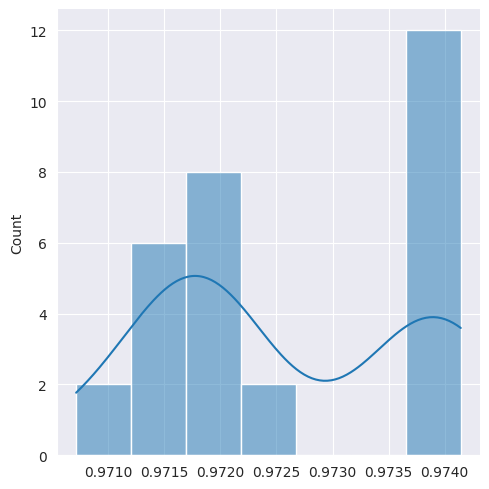

In [130]:
sns.displot(set_acc_originalBRTL, kde=True, bins=7, stat='count')

In [131]:
print(f"{set_acc_originalBRTL.mean()} and error {set_acc_originalBRTL.std()}")

0.9725761904761904 and error 0.0011352325023831556


<Axes: >

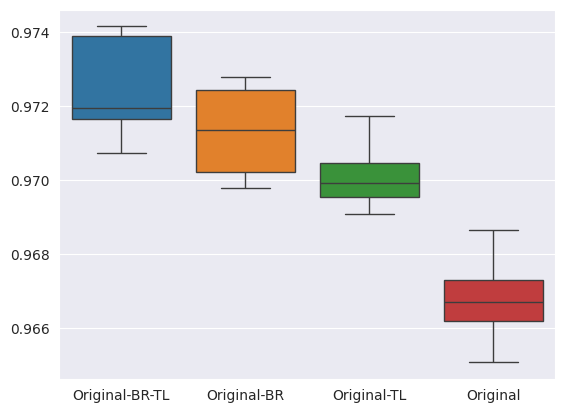

In [132]:
df = pd.Series(set_acc_originalBRTL, name="Original-BR-TL").to_frame().join(pd.Series(set_acc_originalBR, name="Original-BR")).join(pd.Series(set_acc_originalTL, name="Original-TL")).join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

In [133]:
U1, pvalue = mannwhitneyu(set_acc_originalBRTL, set_acc_originalBR, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 0.0003353829537545678 assess that the alternative hypothesis is accepted.


In [134]:
U1, pvalue = mannwhitneyu(set_acc_originalBRTL, set_acc_originalTL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 4.4825437466704567e-10 assess that the alternative hypothesis is accepted.


##### Analisis bottom_left-original-top_right

In [136]:

set_acc_originalBLTR = np.array(models_grouped_trainsize_80.model_groups.get('bottom_left-original-top_right').acc_scores())

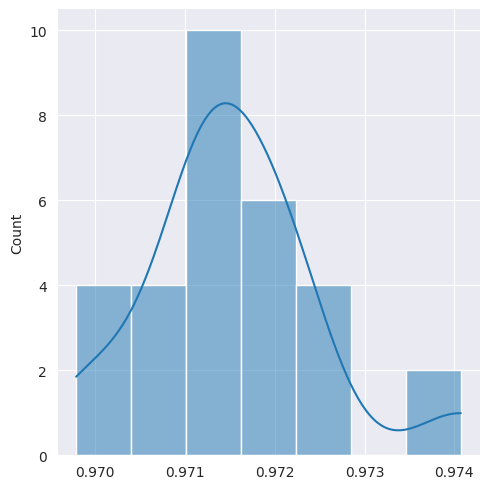

In [138]:
sns.displot(set_acc_originalBLTR, kde=True, bins=7, stat='count')

<Axes: >

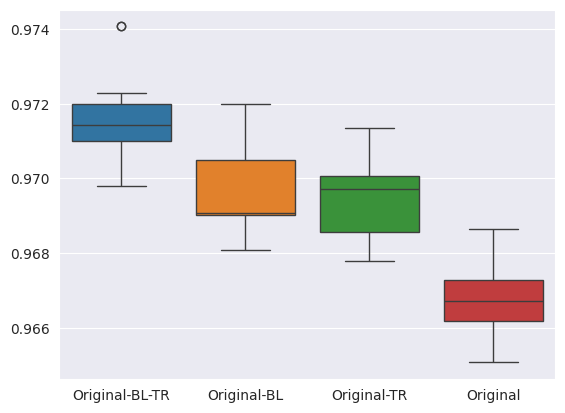

In [139]:
df = pd.Series(set_acc_originalBLTR, name="Original-BL-TR").to_frame().join(pd.Series(set_acc_originalBL, name="Original-BL")).join(pd.Series(set_acc_originalTR, name="Original-TR")).join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

In [140]:
U1, pvalue = mannwhitneyu(set_acc_originalBLTR, set_acc_originalBL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 6.82860373555048e-07 assess that the alternative hypothesis is accepted.


In [141]:
U1, pvalue = mannwhitneyu(set_acc_originalBLTR, set_acc_originalTR, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 1.5803696282202704e-08 assess that the alternative hypothesis is accepted.


#### bottom_left-bottom_right-original

In [144]:
set_acc_originalBLBR = np.array(models_grouped_trainsize_80.model_groups.get('bottom_left-bottom_right-original').acc_scores())

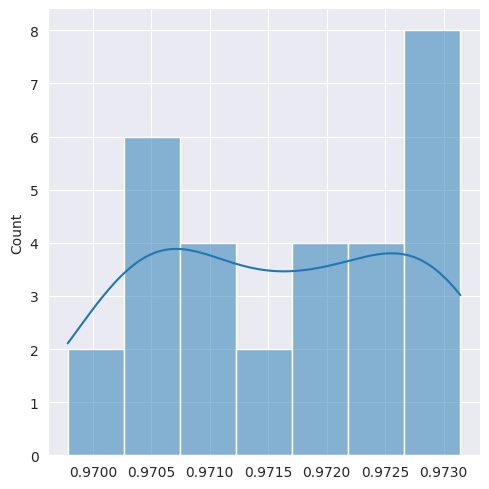

In [145]:
sns.displot(set_acc_originalBLBR, kde=True, bins=7, stat='count')

<Axes: >

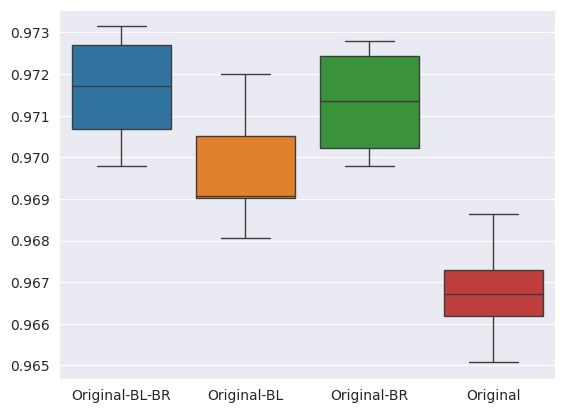

In [146]:
df = pd.Series(set_acc_originalBLBR, name="Original-BL-BR").to_frame().join(pd.Series(set_acc_originalBL, name="Original-BL")).join(pd.Series(set_acc_originalBR, name="Original-BR")).join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

In [147]:
print(f"{set_acc_originalBLBR.mean()} and error {set_acc_originalBLBR.std()}")

0.9715904761904763 and error 0.0010865493864344222


In [148]:
U1, pvalue = mannwhitneyu(set_acc_originalBLBR, set_acc_originalBL, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is accepted.")

The pvalue: 6.88442767237434e-07 assess that the alternative hypothesis is accepted.


In [150]:
U1, pvalue = mannwhitneyu(set_acc_originalBLBR, set_acc_originalBR, alternative="greater")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.07393709044508548 assess that the alternative hypothesis is rejected.


#### bottom_right-original-top_right

In [151]:
set_acc_originalBRTR = np.array(models_grouped_trainsize_80.model_groups.get('bottom_right-original-top_right').acc_scores())

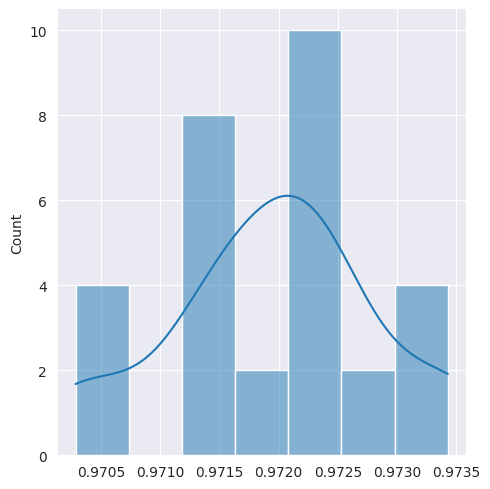

In [153]:
sns.displot(set_acc_originalBRTR, kde=True, bins=7, stat='count')

In [170]:
print(f"{set_acc_originalBRTR.mean()} and error {set_acc_originalBRTR.std()}")

0.9719523809523809 and error 0.0008719618456775866


<Axes: >

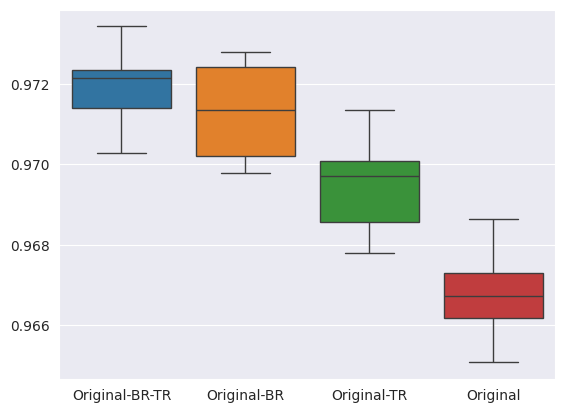

In [155]:
df = pd.Series(set_acc_originalBRTR, name="Original-BR-TR").to_frame().join(pd.Series(set_acc_originalBR, name="Original-BR")).join(pd.Series(set_acc_originalTR, name="Original-TR")).join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

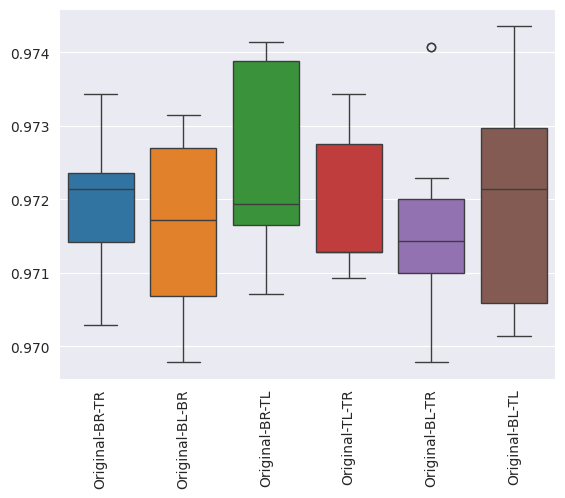

In [174]:
df = pd.Series(set_acc_originalBRTR, name="Original-BR-TR"
              ).to_frame().join(pd.Series(set_acc_originalBLBR, name="Original-BL-BR")
                ).join(pd.Series(set_acc_originalBRTL, name="Original-BR-TL")
                      ).join(pd.Series(set_acc_originalTLTR, name="Original-TL-TR")
                            ).join(pd.Series(set_acc_originalBLTR, name="Original-BL-TR")
                                  ).join(pd.Series(set_acc_originalBLTL, name="Original-BL-TL"))
sns.boxplot(data=df)
plt.xticks(rotation=90)

plt.show()

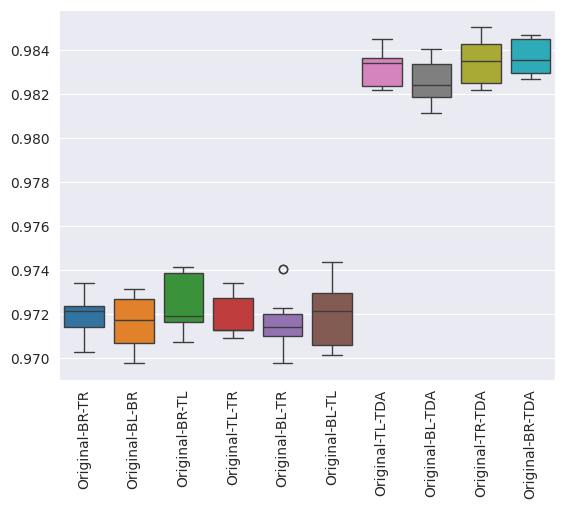

In [183]:
df = pd.Series(set_acc_originalBRTR, name="Original-BR-TR"
              ).to_frame().join(pd.Series(set_acc_originalBLBR, name="Original-BL-BR")
                ).join(pd.Series(set_acc_originalBRTL, name="Original-BR-TL")
                      ).join(pd.Series(set_acc_originalTLTR, name="Original-TL-TR")
                            ).join(pd.Series(set_acc_originalBLTR, name="Original-BL-TR")
                                  ).join(pd.Series(set_acc_originalBLTL, name="Original-BL-TL")
                                        ).join(pd.Series(set_acc_originalTLD, name="Original-TL-TDA")
                                              ).join(pd.Series(set_acc_originalBLD, name="Original-BL-TDA")
                                                    ).join(pd.Series(set_acc_originalTRD, name="Original-TR-TDA")
                                                          ).join(pd.Series(set_acc_originalBRD, name="Original-BR-TDA"))
sns.boxplot(data=df)
plt.xticks(rotation=90)

plt.show()

In [ ]:
set_acc_originalBRTR = np.array(models_grouped_trainsize_80.model_groups.get('bottom_right-original-top_right').acc_scores())

In [175]:
U1, pvalue = mannwhitneyu(set_acc_originalBRTR, set_acc_originalBLBR, alternative="two-sided")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.3171855831518262 assess that the alternative hypothesis is rejected.


In [176]:
U1, pvalue = mannwhitneyu(set_acc_originalBRTR, set_acc_originalBRTL, alternative="two-sided")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.10462740866470721 assess that the alternative hypothesis is rejected.


In [177]:
U1, pvalue = mannwhitneyu(set_acc_originalBRTR, set_acc_originalTLTR, alternative="two-sided")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.2748966613484619 assess that the alternative hypothesis is rejected.


In [178]:
U1, pvalue = mannwhitneyu(set_acc_originalBRTR, set_acc_originalBLTL, alternative="two-sided")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.935035084454592 assess that the alternative hypothesis is rejected.


#### bottom_left-original-tda-top_left

In [184]:
set_acc_originalBLTLD = np.array(models_grouped_trainsize_80.model_groups.get('bottom_left-original-tda-top_left').acc_scores())

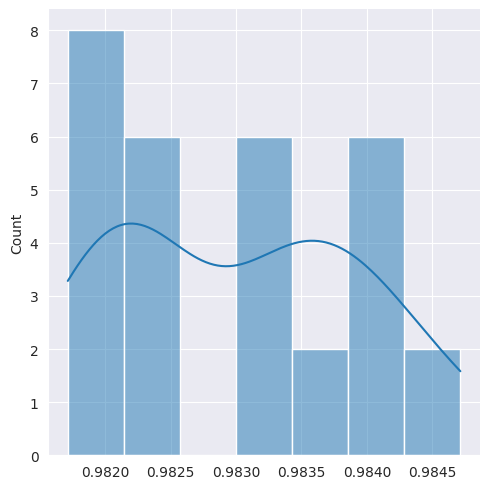

In [185]:
sns.displot(set_acc_originalBLTLD, kde=True, bins=7, stat='count')

In [186]:
print(f"{set_acc_originalBLTLD.mean()} and error {set_acc_originalBLTLD.std()}")

0.9830047619047619 and error 0.0009270928398962161


<Axes: >

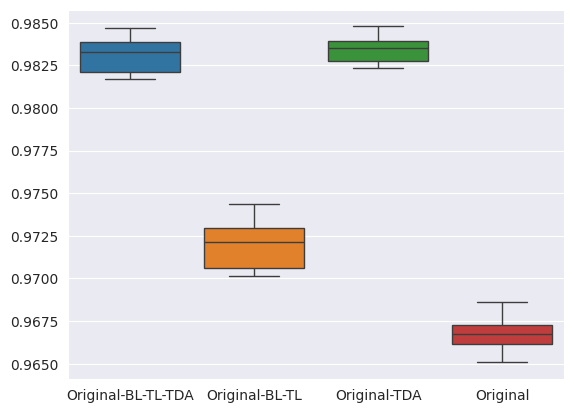

In [189]:
df = pd.Series(set_acc_originalBLTLD, name="Original-BL-TL-TDA").to_frame().join(pd.Series(set_acc_originalBLTL, name="Original-BL-TL")).join(pd.Series(set_acc_originaltda, name="Original-TDA")).join(pd.Series(set_acc_original, name="Original"))
sns.boxplot(data=df)

In [190]:
U1, pvalue = mannwhitneyu(set_acc_originalBLTLD, set_acc_originaltda, alternative="two-sided")
print(f"The pvalue: {pvalue} assess that the alternative hypothesis is rejected.")

The pvalue: 0.08687336180376247 assess that the alternative hypothesis is rejected.


In [ ]:
#### original-tda-top_left-top_right


In [191]:
set_acc_originalTLTRD = np.array(models_grouped_trainsize_80.model_groups.get('original-tda-top_left-top_right').acc_scores())

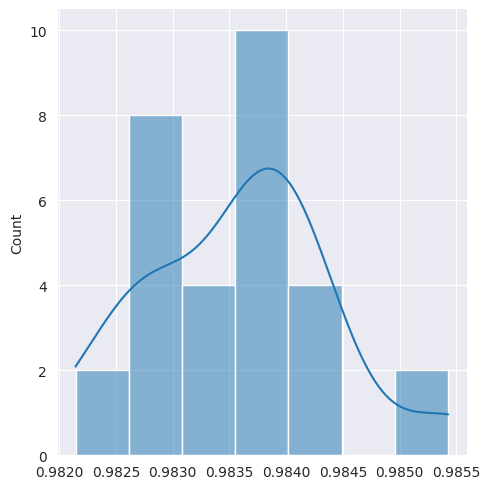

In [192]:
sns.displot(set_acc_originalTLTRD, kde=True, bins=7, stat='count')

In [193]:
print(f"{set_acc_originalTLTRD.mean()} and error {set_acc_originalTLTRD.std()}")

0.9835857142857143 and error 0.0008052548504353613
